In [58]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [25]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)


In [26]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [27]:
df = pd.read_csv('../data/data-tidy/perc_disagreement_in_time.csv')

In [69]:
df_before_merged = pd.DataFrame()
df_after_merged = pd.DataFrame()

t = df.submission_id.nunique()
pbar = tqdm(total=t)
i=0
for subm_id, sub_df in df.groupby('submission_id'):
    i+=1
    sub_df.reset_index(drop=True, inplace=True)
    sub_df['created'] = pd.to_datetime(sub_df['created'], format='%Y-%m-%d %H:%M:%S')
    start = sub_df.iloc[0]['created']
    eighteen_h = start + pd.Timedelta(18, 'h', hours=18)

    # set the streshold (18h) and split the dataframe
    df_before = sub_df[sub_df['created'] < eighteen_h]
    df_after = sub_df[sub_df['created'] > eighteen_h]
    df_before.reset_index(drop=True, inplace=True)
    df_after.reset_index(drop=True, inplace=True)

    # we take the same number of messages before and after (otherwise we get error when we run the inference model)
    if len(df_before) > len(df_after):
        df_before = df_before.iloc[:len(df_after)]
    else:
        df_after = df_after.iloc[:len(df_before)]

    # merge the dataframes
    df_before_merged = pd.concat([df_before_merged, df_before], axis=0)
    df_after_merged = pd.concat([df_after_merged, df_after], axis=0)

    pbar.update(1)

    if i == 1000:
        break

    

 16%|█▌        | 1000/6305 [01:57<10:23,  8.51it/s]


In [70]:
df_before_merged

,submission_id,final_judg,created,ESH_perc,NAH_perc,NTA_perc,YTA_perc,unsure_perc,no_vote_perc,depth,text_flair
0,10020p0,Not the A-hole,2022-12-31 19:46:22,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,NaN
1,10020p0,Not the A-hole,2022-12-31 19:48:32,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.0,NTA
0,100govo,Not the A-hole,2023-01-01 10:09:29,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,NaN
1,100govo,Not the A-hole,2023-01-01 10:19:15,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.0,NTA
2,100govo,Not the A-hole,2023-01-01 10:19:32,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.0,NTA
...,...,...,...,...,...,...,...,...,...,...,...
1094,16iraol,Not the A-hole,2023-09-15 01:14:50,0.002740,0.004566,0.416438,0.008219,0.002740,0.565297,2.0,NaN
1095,16iraol,Not the A-hole,2023-09-15 01:14:55,0.002737,0.004562,0.416058,0.008212,0.002737,0.565693,0.0,NaN
1096,16iraol,Not the A-hole,2023-09-15 01:15:30,0.002735,0.004558,0.415679,0.008204,0.002735,0.566089,2.0,NaN
1097,16iraol,Not the A-hole,2023-09-15 01:15:36,0.002732,0.004554,0.416211,0.008197,0.002732,0.565574,0.0,NTA


In [71]:
df_after_merged

,submission_id,final_judg,created,ESH_perc,NAH_perc,NTA_perc,YTA_perc,unsure_perc,no_vote_perc,depth,text_flair
0,10020p0,Not the A-hole,2023-01-03 01:05:00,0.000496,0.003970,0.584615,0.001985,0.003474,0.405459,1.0,NaN
1,10020p0,Not the A-hole,2023-01-03 01:10:16,0.000496,0.003968,0.584325,0.001984,0.003472,0.405754,5.0,NaN
0,100govo,Not the A-hole,2023-01-02 04:10:30,0.011696,0.001559,0.516959,0.006238,0.003509,0.460039,0.0,NTA
1,100govo,Not the A-hole,2023-01-02 04:12:37,0.011691,0.001559,0.517147,0.006235,0.003507,0.459860,0.0,NTA
2,100govo,Not the A-hole,2023-01-02 04:12:51,0.011687,0.001558,0.516946,0.006233,0.003506,0.460070,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1094,16iraol,Not the A-hole,2023-10-02 15:34:37,0.002645,0.006348,0.376620,0.010579,0.002909,0.600899,2.0,NaN
1095,16iraol,Not the A-hole,2023-10-03 01:31:19,0.002644,0.006346,0.376520,0.010576,0.002909,0.601005,6.0,NaN
1096,16iraol,Not the A-hole,2023-10-03 01:38:56,0.002643,0.006344,0.376421,0.010574,0.002908,0.601110,4.0,NaN
1097,16iraol,Not the A-hole,2023-10-03 01:56:15,0.002643,0.006342,0.376321,0.010571,0.002907,0.601216,3.0,NaN


In [64]:
df_before_merged.final_judg.unique()

array(['Not the A-hole', 'Asshole', 'Everyone Sucks', 'No A-holes here'],
      dtype=object)

Text(0.5, 0.98, 'BEFORE')

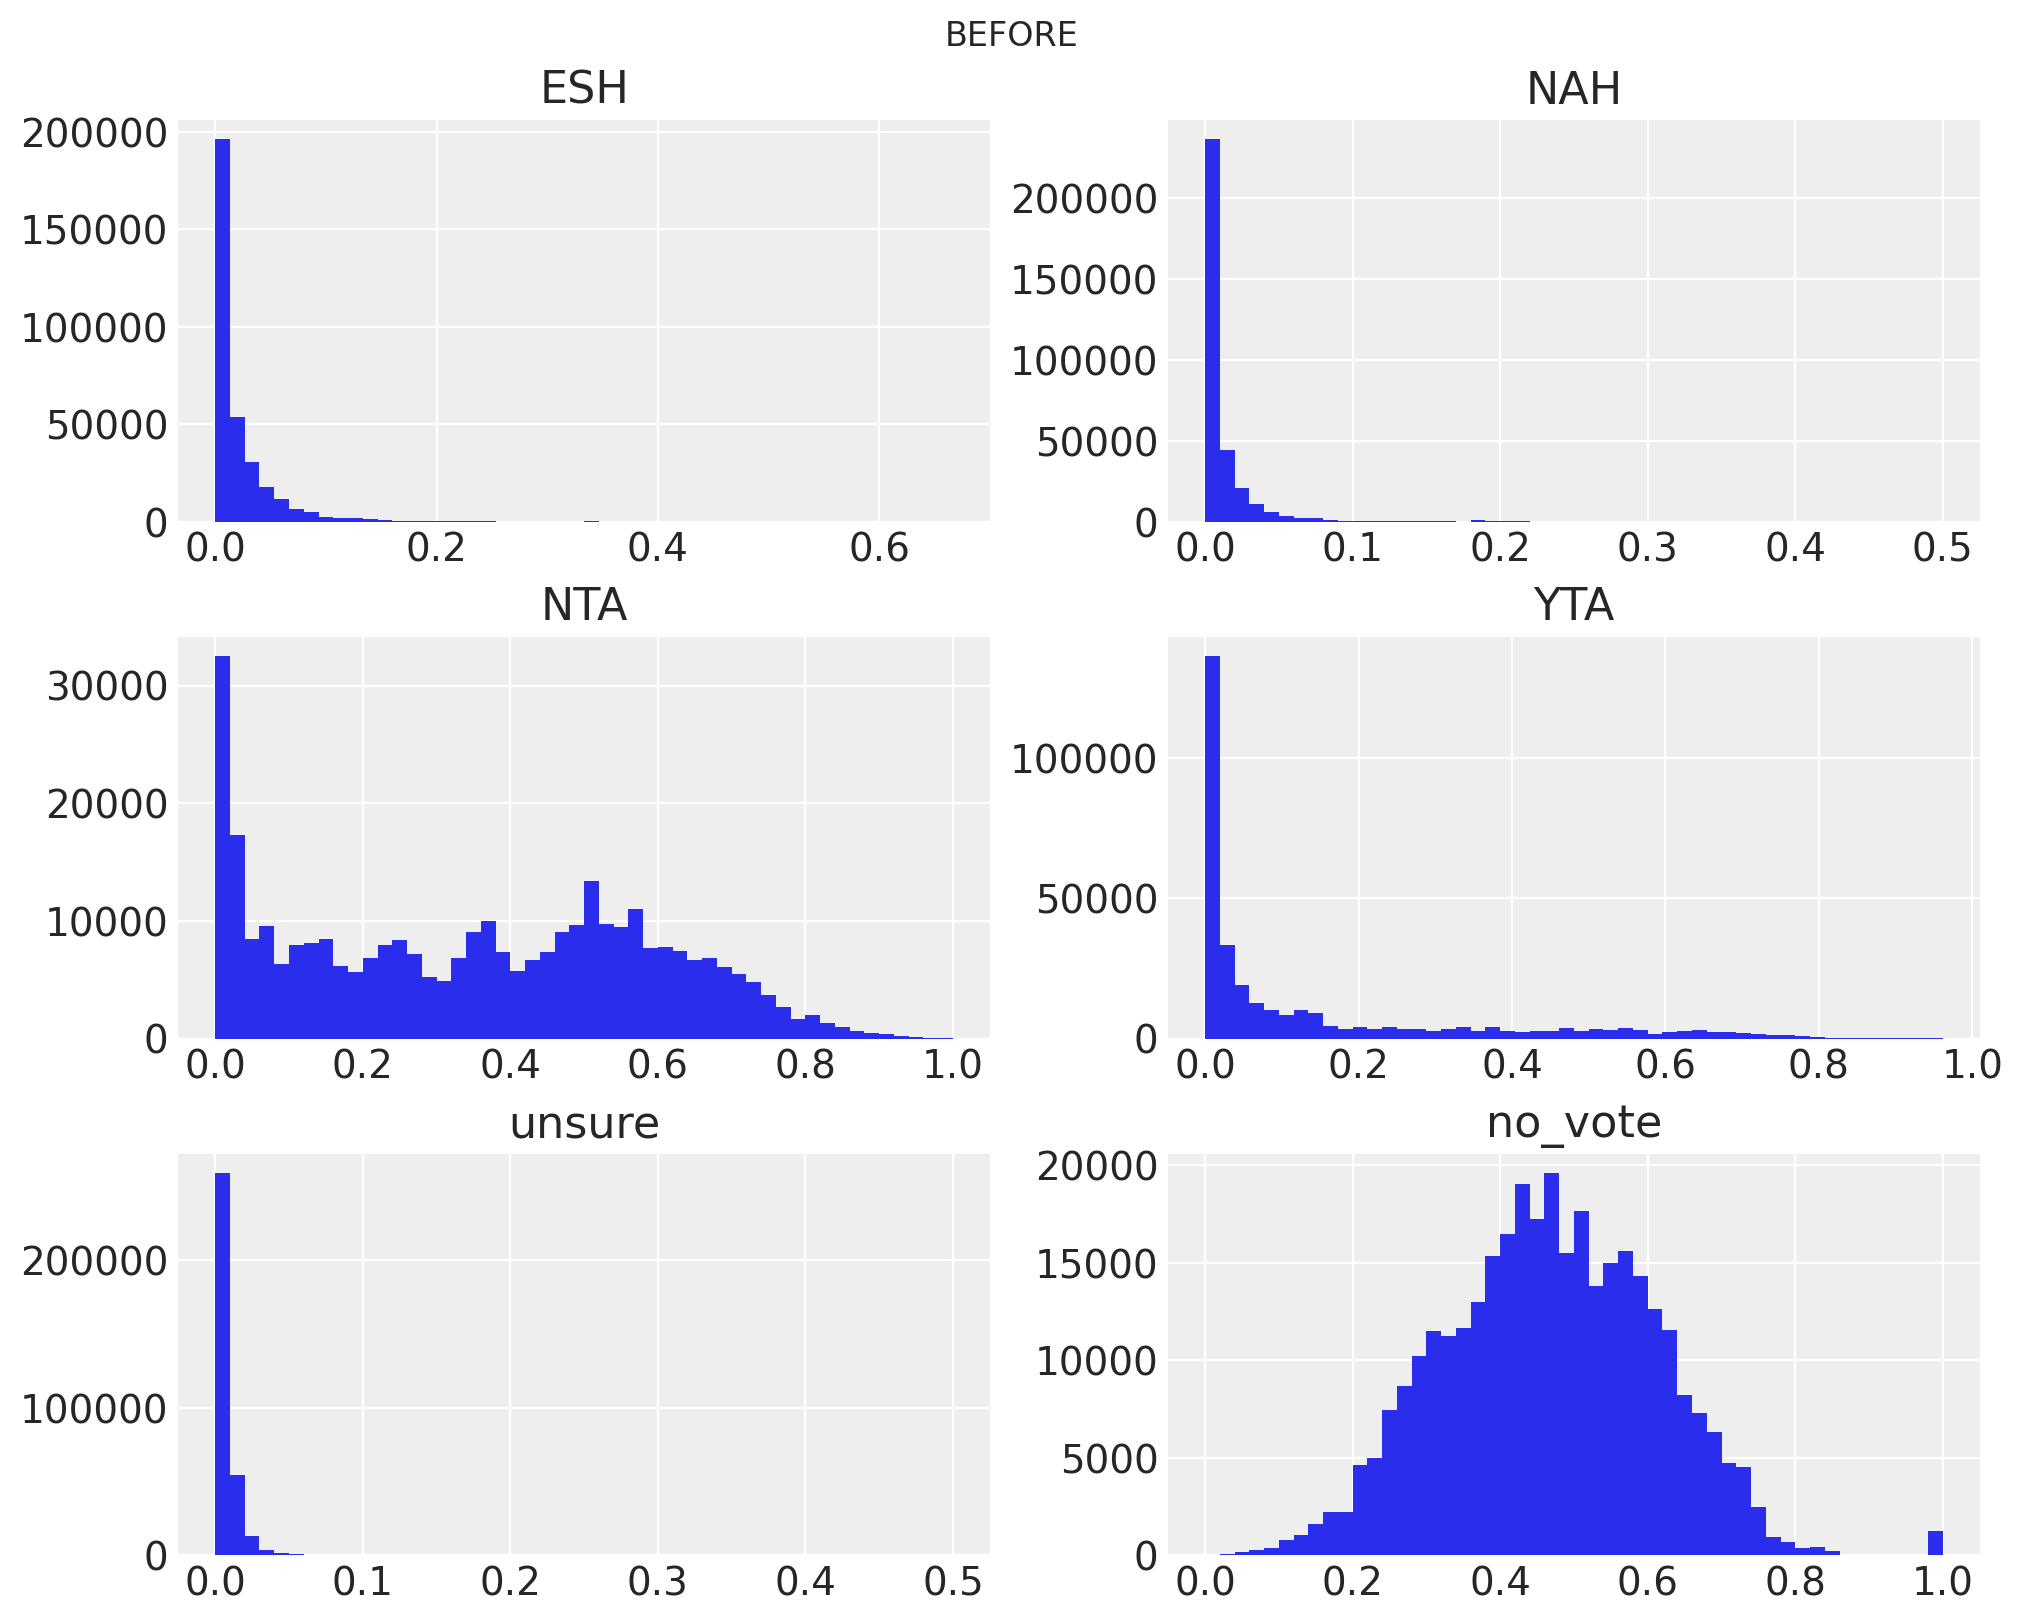

In [72]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))


ax[0, 0].hist(df_before_merged['ESH_perc'], bins=50)
ax[0, 0].set_title('ESH')
#ax[0, 0].set_xlim(0, 0.1, 0.005)
ax[0, 1].hist(df_before_merged['NAH_perc'], bins=50)
ax[0, 1].set_title('NAH')
#ax[0, 1].set_xlim(0, 0.1, 0.005)
ax[1, 0].hist(df_before_merged['NTA_perc'], bins=50)
ax[1, 0].set_title('NTA')
#ax[1, 0].set_xlim(0.18, 0.22, 0.005)
ax[1, 1].hist(df_before_merged['YTA_perc'], bins=50)
ax[1, 1].set_title('YTA')
#ax[1, 1].set_xlim(0.08, 0.112, 0.005)
ax[2, 0].hist(df_before_merged['unsure_perc'], bins=50)
ax[2, 0].set_title('unsure')
#ax[2, 0].set_xlim(0.005, 0.015, 0.005)
ax[2, 1].hist(df_before_merged['no_vote_perc'], bins=50)
ax[2, 1].set_title('no_vote')
#ax[2, 1].set_xlim(0.6, 0.7, 0.05)


plt.suptitle('BEFORE')


Text(0.5, 0.98, 'AFTER')

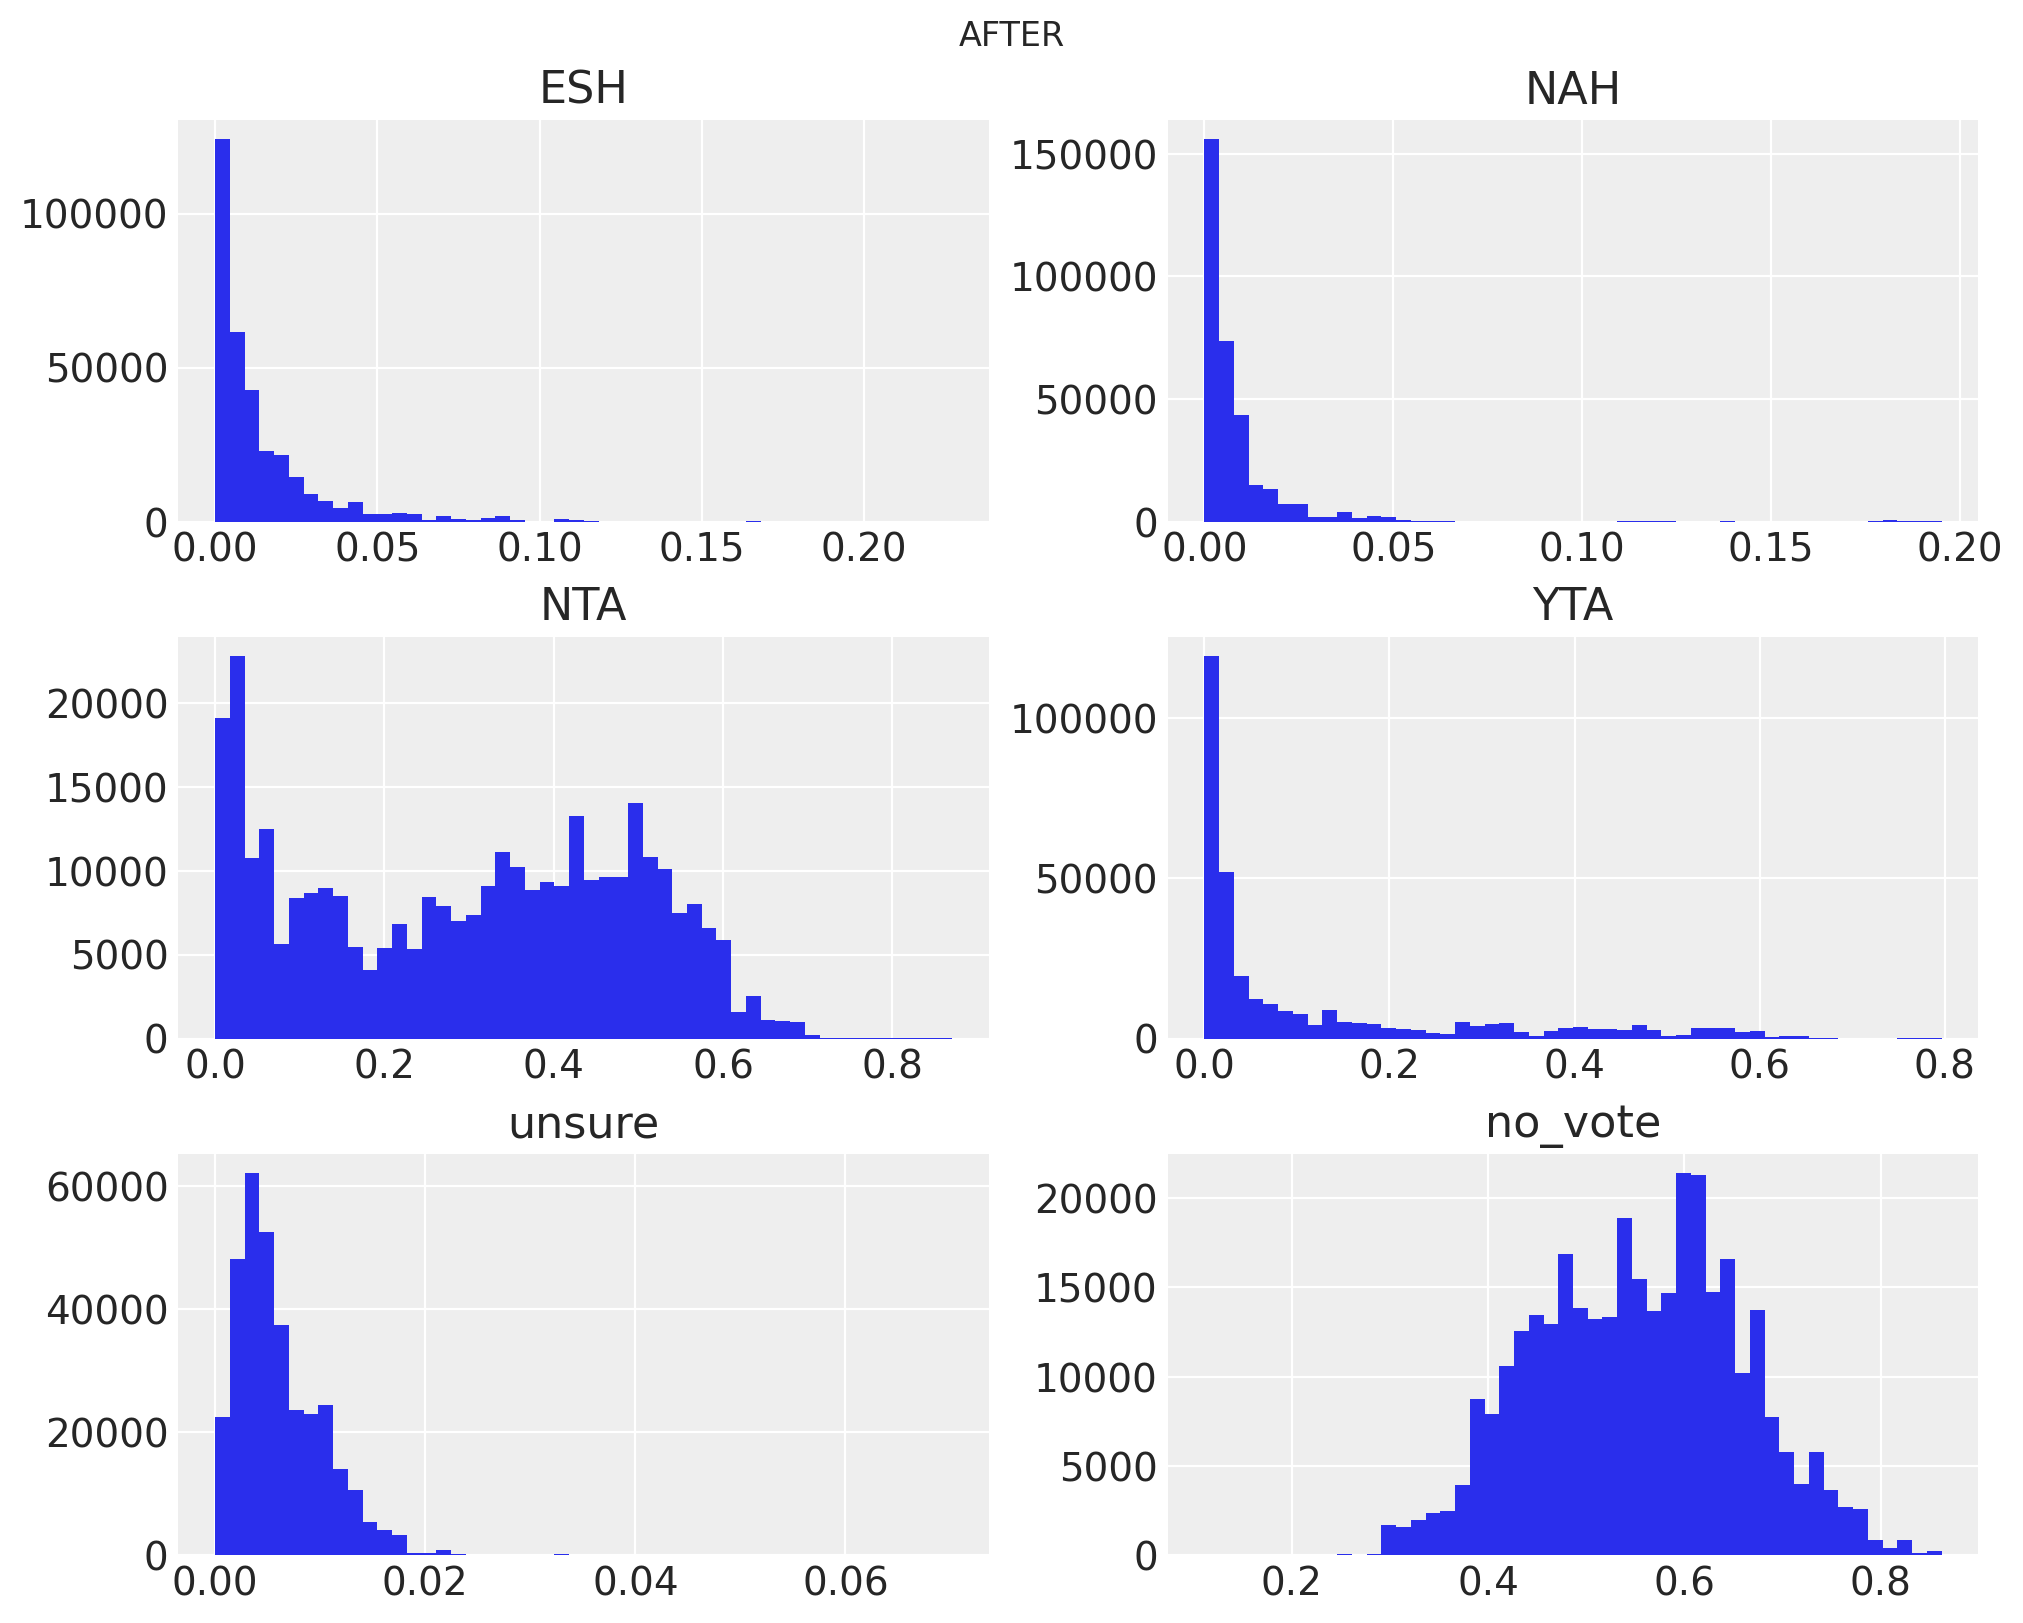

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))

ax[0, 0].hist(df_after_merged['ESH_perc'], bins=50)
ax[0, 0].set_title('ESH')
ax[0, 1].hist(df_after_merged['NAH_perc'], bins=50)
ax[0, 1].set_title('NAH')
ax[1, 0].hist(df_after_merged['NTA_perc'], bins=50)
ax[1, 0].set_title('NTA')
ax[1, 1].hist(df_after_merged['YTA_perc'], bins=50)
ax[1, 1].set_title('YTA')
ax[2, 0].hist(df_after_merged['unsure_perc'], bins=50)
ax[2, 0].set_title('unsure')
ax[2, 1].hist(df_after_merged['no_vote_perc'], bins=50)
ax[2, 1].set_title('no_vote')

plt.suptitle('AFTER')

In [74]:
'''
Bh_before = df_before[df_before.created > df_before.iloc[-1]['created']-pd.Timedelta(10, 'h')]
Bh_after = df_after[df_after.created < df_after.iloc[0]['created']+pd.Timedelta(10, 'h')]

#Bh_before['final_verdict'] = 0
#Bh_after['final_verdict'] = 1

Bh_before = Bh_before.iloc[0][['ESH_perc', 'NAH_perc', 'NTA_perc', 'YTA_perc', 'unsure_perc', 'no_vote_perc']].to_dict()
Bh_after = Bh_after.iloc[-1][['ESH_perc', 'NAH_perc', 'NTA_perc', 'YTA_perc', 'unsure_perc', 'no_vote_perc']].to_dict()
print(Bh_before, '\n', Bh_after)
'''

"\nBh_before = df_before[df_before.created > df_before.iloc[-1]['created']-pd.Timedelta(10, 'h')]\nBh_after = df_after[df_after.created < df_after.iloc[0]['created']+pd.Timedelta(10, 'h')]\n\n#Bh_before['final_verdict'] = 0\n#Bh_after['final_verdict'] = 1\n\nBh_before = Bh_before.iloc[0][['ESH_perc', 'NAH_perc', 'NTA_perc', 'YTA_perc', 'unsure_perc', 'no_vote_perc']].to_dict()\nBh_after = Bh_after.iloc[-1][['ESH_perc', 'NAH_perc', 'NTA_perc', 'YTA_perc', 'unsure_perc', 'no_vote_perc']].to_dict()\nprint(Bh_before, '\n', Bh_after)\n"

$$ BA_{ESH} \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_1 BB_{ESH} + \beta_2 V $$
$$ \alpha \sim \text{Normal}(0, 10) $$ 
$$ \beta_1 \sim \text{HalfNormal}(0, 0.01) $$
$$ \beta_2 \sim \text{Uniform}(0, 0.01) $$ 
$$ \sigma \sim \text{Uniform}(0, 10) $$

beta_1 has range [0, 0.6] 

beta_2 has range [0, 0.2] 


In [75]:
#one_hot_encoded_data = pd.get_dummies(df_before_merged, columns = ['final_judg'], dtype=int)
#one_hot_encoded_data

In [76]:
BB = df_before_merged["ESH_perc"].values
BA = df_after_merged["ESH_perc"].values
#V = one_hot_encoded_data[['final_judg_Asshole', 'final_judg_Everyone Sucks', 'final_judg_No A-holes here', 'final_judg_Not the A-hole']].values# before or after does not matter because the verdict is the same for the post
#V = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=int)
le = LabelEncoder()
le.fit(df_before_merged.final_judg)
V = le.transform(df_before_merged.final_judg)

In [78]:
V

array([3, 3, 3, ..., 3, 3, 3])

In [79]:
print(list(le.classes_))
print(le.transform(list(le.classes_)))

['Asshole', 'Everyone Sucks', 'No A-holes here', 'Not the A-hole']
[0 1 2 3]


In [80]:
with pm.Model() as m_SW:

    # priors
    alpha = pm.Normal("alpha", 0, 10) 
    sigma = pm.Uniform("sigma", 0, 10)

    #t = alpha[verdict]
    beta1 = pm.HalfNormal("beta1", 0.01)
    beta2 = pm.Uniform("beta2", 0.01)  

    mu = alpha + beta1*BB + beta2*V  # linear model # deterministic variable
    Ylikelihood  = pm.Normal("y", mu, sigma, observed=BA)  # likelihood

    # posterior
    idata_m_SHW = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, beta1, beta2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2875 seconds.


In [81]:
az.summary(idata_m_SHW)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.016,0.000,-0.016,-0.016,0.0,0.0,1819.0,2176.0,1.0
sigma,0.018,0.000,0.018,0.018,0.0,0.0,3077.0,2543.0,1.0
beta1,0.445,0.001,0.443,0.446,0.0,0.0,2058.0,2207.0,1.0
beta2,0.010,0.000,0.010,0.010,0.0,0.0,2133.0,1732.0,1.0


In [82]:
idata_m_SHW = idata_m_SHW.to_dataframe()
idata_m_SHW.head()

,chain,draw,"(posterior, alpha)","(posterior, sigma)","(posterior, beta1)","(posterior, beta2)","(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, step_size)","(sample_stats, tree_depth)","(sample_stats, largest_eigval)","(sample_stats, acceptance_rate)","(sample_stats, reached_max_treedepth)","(sample_stats, diverging)","(sample_stats, perf_counter_diff)","(sample_stats, lp)","(sample_stats, index_in_trajectory)","(sample_stats, energy)","(sample_stats, process_time_diff)","(sample_stats, step_size_bar)","(sample_stats, energy_error)","(sample_stats, smallest_eigval)","(sample_stats, n_steps)"
0,0,0,-0.016356,0.018235,0.443812,0.01,393.552203,-0.259750,0.819799,3,NaN,0.987848,False,False,0.076736,860889.505657,-2,-860888.144790,0.078125,0.663279,-0.228411,NaN,7.0
1,0,1,-0.016399,0.018204,0.445244,0.01,393.629205,0.093173,0.819799,3,NaN,0.954030,False,False,0.080662,860889.547929,5,-860888.716980,0.078125,0.663279,0.042251,NaN,7.0
2,0,2,-0.016411,0.018156,0.445015,0.01,393.710159,0.495749,0.819799,2,NaN,0.716297,False,False,0.037482,860885.456805,2,-860885.269185,0.031250,0.663279,0.495749,NaN,3.0
3,0,3,-0.016385,0.018223,0.444815,0.01,393.747907,-0.453124,0.819799,3,NaN,0.948953,False,False,0.070679,860888.635927,-3,-860882.854371,0.078125,0.663279,-0.416352,NaN,7.0
4,0,4,-0.016349,0.018229,0.444983,0.01,393.818841,0.254885,0.819799,2,NaN,0.834240,False,False,0.035366,860886.666540,-1,-860885.930017,0.031250,0.663279,0.254885,NaN,3.0


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


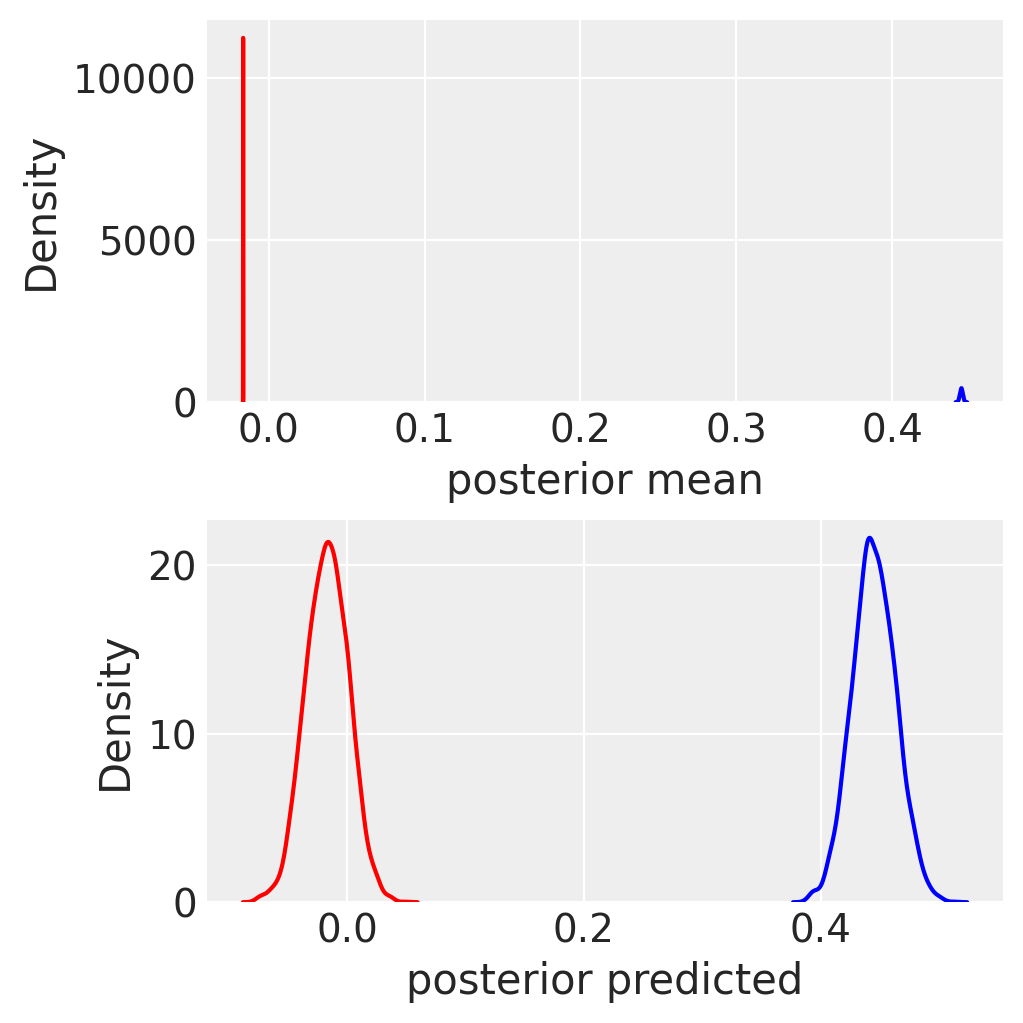

In [85]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 5))

# Plot of contrast using distribution of mean only  ---------
sns.kdeplot(idata_m_SHW[("posterior", "alpha")], color="red", ax=ax0)
sns.kdeplot(idata_m_SHW[("posterior", "beta1")], color="blue", ax=ax0)
ax0.set(xlabel="posterior mean")

# # Plot of contrast using full posterior distribution ---------
W0 = stats.norm.rvs(
    loc=idata_m_SHW[("posterior", "alpha")],
    scale=idata_m_SHW[("posterior", "sigma")],
    # size=n   (*see note below)
)

W1 = stats.norm.rvs(
    loc=idata_m_SHW[("posterior", "beta1")],
    scale=idata_m_SHW[("posterior", "sigma")],
)

sns.kdeplot(W0, color="red", label="", ax=ax1)
sns.kdeplot(W1, color="blue", label="", ax=ax1)
ax1.set(xlabel="posterior predicted")
ax1.legend()

# *unlike in R, size has to be the same as the length of the vectors